In [1]:
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cosine, cdist
from collections import Counter

In [2]:
with open('raw_sentences.txt') as f:
    sentences = f.read().replace('\n', ' ').replace(' nt', '\'nt').lower()

In [3]:
# 用 <unk> 取代罕見字
c = Counter(sentences.split())
words = [w if c[w] > 5 else '<unk>' for w in sentences.split()]
c = Counter(words)

In [4]:
inv_vocab = np.array([w for w, _ in c.most_common()])
vocab = dict([(w, i) for i, w in enumerate(inv_vocab)])
word_freq = dict([(w, float(cnt) / len(words)) for w, cnt in c.most_common()])
word_ids = np.array([vocab[w] for w in words])

In [5]:
print u'全部的字數:', len(words)
print u'字典的字數:', len(vocab)
print u'最常見的單字:', c.most_common()[:5]

全部的字數: 740731
字典的字數: 261
最常見的單字: [('.', 80974), ('it', 29200), (',', 24583), ('i', 22266), ('to', 19537)]


## CBOW (continuous bag-of-words)

![CBOW](http://sebastianruder.com/content/images/2016/02/cbow.png)

In [6]:
def cbow_batch(window, batch_size):
    x_data, y_data = list(), list()
    for i_center in range(window, len(word_ids) - window):
        wo = word_ids[i_center]
        wi = tuple([word_ids[j] for j in range(i_center - window, i_center + window + 1)
                    if j != i_center])
        x_data.append(wi)
        y_data.append(wo)
        if len(x_data) == batch_size:
            yield x_data, y_data
            x_data, y_data = list(), list()

## Skip-gram

![](http://sebastianruder.com/content/images/2016/02/skip-gram.png)

In [7]:
def skipgram_batch(window, batch_size):
    x_data, y_data = list(), list()
    for i_center in range(window, len(word_ids) - window):
        wi = word_ids[i_center]
        if np.random.rand() < 1 - np.sqrt(1e-4 / word_freq[inv_vocab[wi]]):
            continue
        for i_context in range(i_center - window, i_center + window + 1):
            if i_context == i_center:
                continue
            x_data.append(wi)
            y_data.append([word_ids[i_context]])
            if len(x_data) == batch_size:
                yield x_data, y_data
                x_data, y_data = list(), list()

### [Tensorflow 範例程式](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)中的 batch generator

我實在懶得trace這段code，有興趣自己看。

```python
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels
```

## Build Model

In [8]:
def most_sim_cos(word):
    vw = np.expand_dims(word_vector[vocab[word]], 0)
    sim = np.argsort((1 - cdist(word_vector, vw, 'cosine')).flatten())[::-1]
    return [inv_vocab[i] for i in sim[1:6]]

In [13]:
batch_size = 128
vector_size = 20
window_size = 5
X = tf.placeholder(tf.int32, shape=[batch_size])
Y = tf.placeholder(tf.int32, shape=[batch_size, 1])

wordvec = tf.Variable(tf.random_normal([len(vocab), vector_size]))
vec_X = tf.nn.embedding_lookup(wordvec, X)

nce_weights = tf.Variable(tf.random_normal([len(vocab), vector_size]))
nce_biases = tf.Variable(tf.zeros([len(vocab)]))

nce_loss = tf.nn.nce_loss(nce_weights, nce_biases, vec_X, Y, 10, len(vocab))
loss = tf.reduce_mean(nce_loss)

global_step = tf.Variable(0, trainable=False)
rate = tf.train.exponential_decay(3.0, global_step, 100000, 0.9, staircase=True)
train_op = tf.train.AdadeltaOptimizer(rate).minimize(loss, global_step=global_step)

In [14]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    last_loss = 1e8
    for epoch in range(50):
        losses = []
        for x, y in skipgram_batch(5, batch_size):
            _, loss_val = sess.run([train_op, loss], feed_dict={X: x, Y: y})
            losses.append(loss_val)
        if np.mean(losses) > last_loss:
            break
        word_vector = sess.run(wordvec)
        last_loss = np.mean(losses)
        print epoch, last_loss
        print '    she --> ', most_sim_cos('she')
        print '    office --> ', most_sim_cos('office')

0 16.7523
    she -->  ['is', 'good', 'he', 'now', 'there']
    office -->  ['next', 'family', 'because', 'without', 'with']
1 6.78889
    she -->  ['not', 'if', 'time', 'think', 'but']
    office -->  ['family', 'without', 'next', 'home', 'than']
2 4.68114
    she -->  ['then', 'no', 'he', '.', 'time']
    office -->  ['without', 'law', 'family', 'also', 'into']
3 3.78708
    she -->  ['he', 'time', 'and', 'over', 'we']
    office -->  ['without', 'by', 'also', 'law', 'court']
4 3.4548
    she -->  ['that', 'i', 'man', 'so', 'he']
    office -->  ['without', 'by', ';', 'own', "were'nt"]
5 3.37304
    she -->  ['so', 'program', 'public', 'now', 'he']
    office -->  ['also', 'of', 'first', 'play', 'high']
6 3.36365
    she -->  ['he', 'so', 'me', 'this', 'school']
    office -->  ['company', 'one', 'not', 'game', 'of']
7 3.36117
    she -->  ['he', 'program', 'that', 'never', 'school']
    office -->  ['of', 'first', 'game', 'play', 'by']
8 3.35935
    she -->  ['my', 'he', 'so', 'poli

## Visualization

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(n_components=2)
vec_2d = tsne.fit_transform(word_vector)

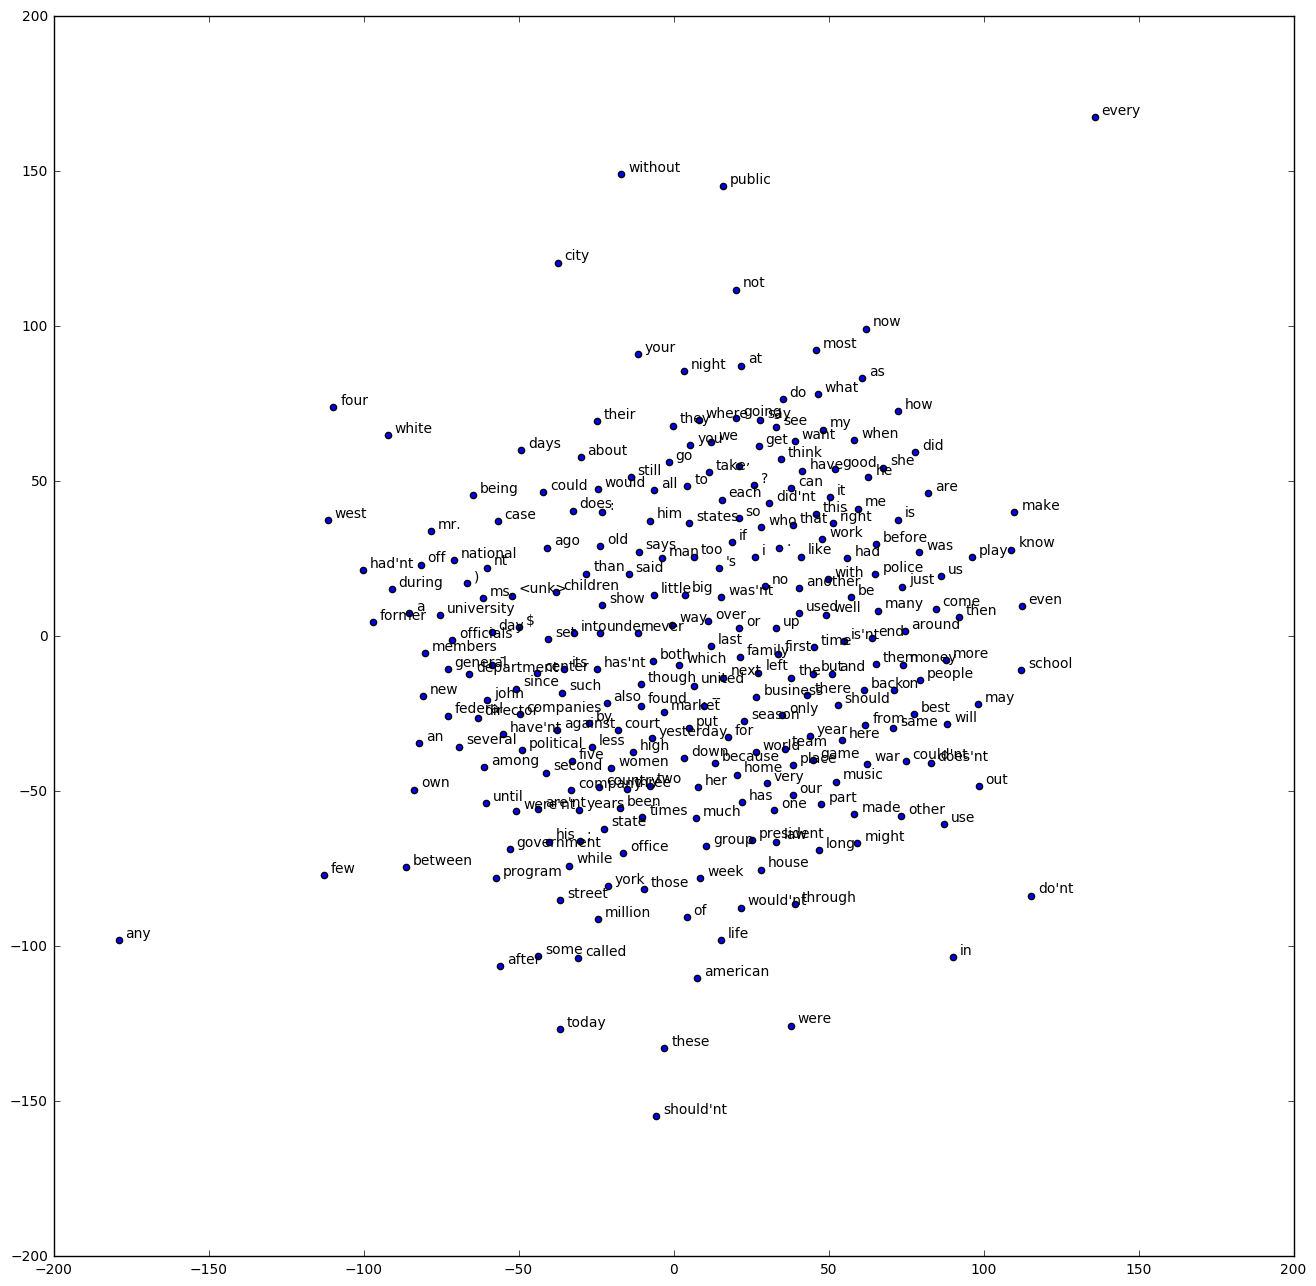

In [16]:
plt.figure(figsize=(16, 16))
for i, word in enumerate(inv_vocab):
    x, y = vec_2d[i]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')